In [2]:
from whited_mkde import *
from fourier_density_estimation import *

In [1]:
"""
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.linalg import fractional_matrix_power, svd
from sklearn.decomposition import PCA
from typing import Tuple, Optional
import time

# Apple-style plotting aesthetics for Retina Display
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150 # High DPI for your Mac screen
np.random.seed(2026) # Future-proof seed

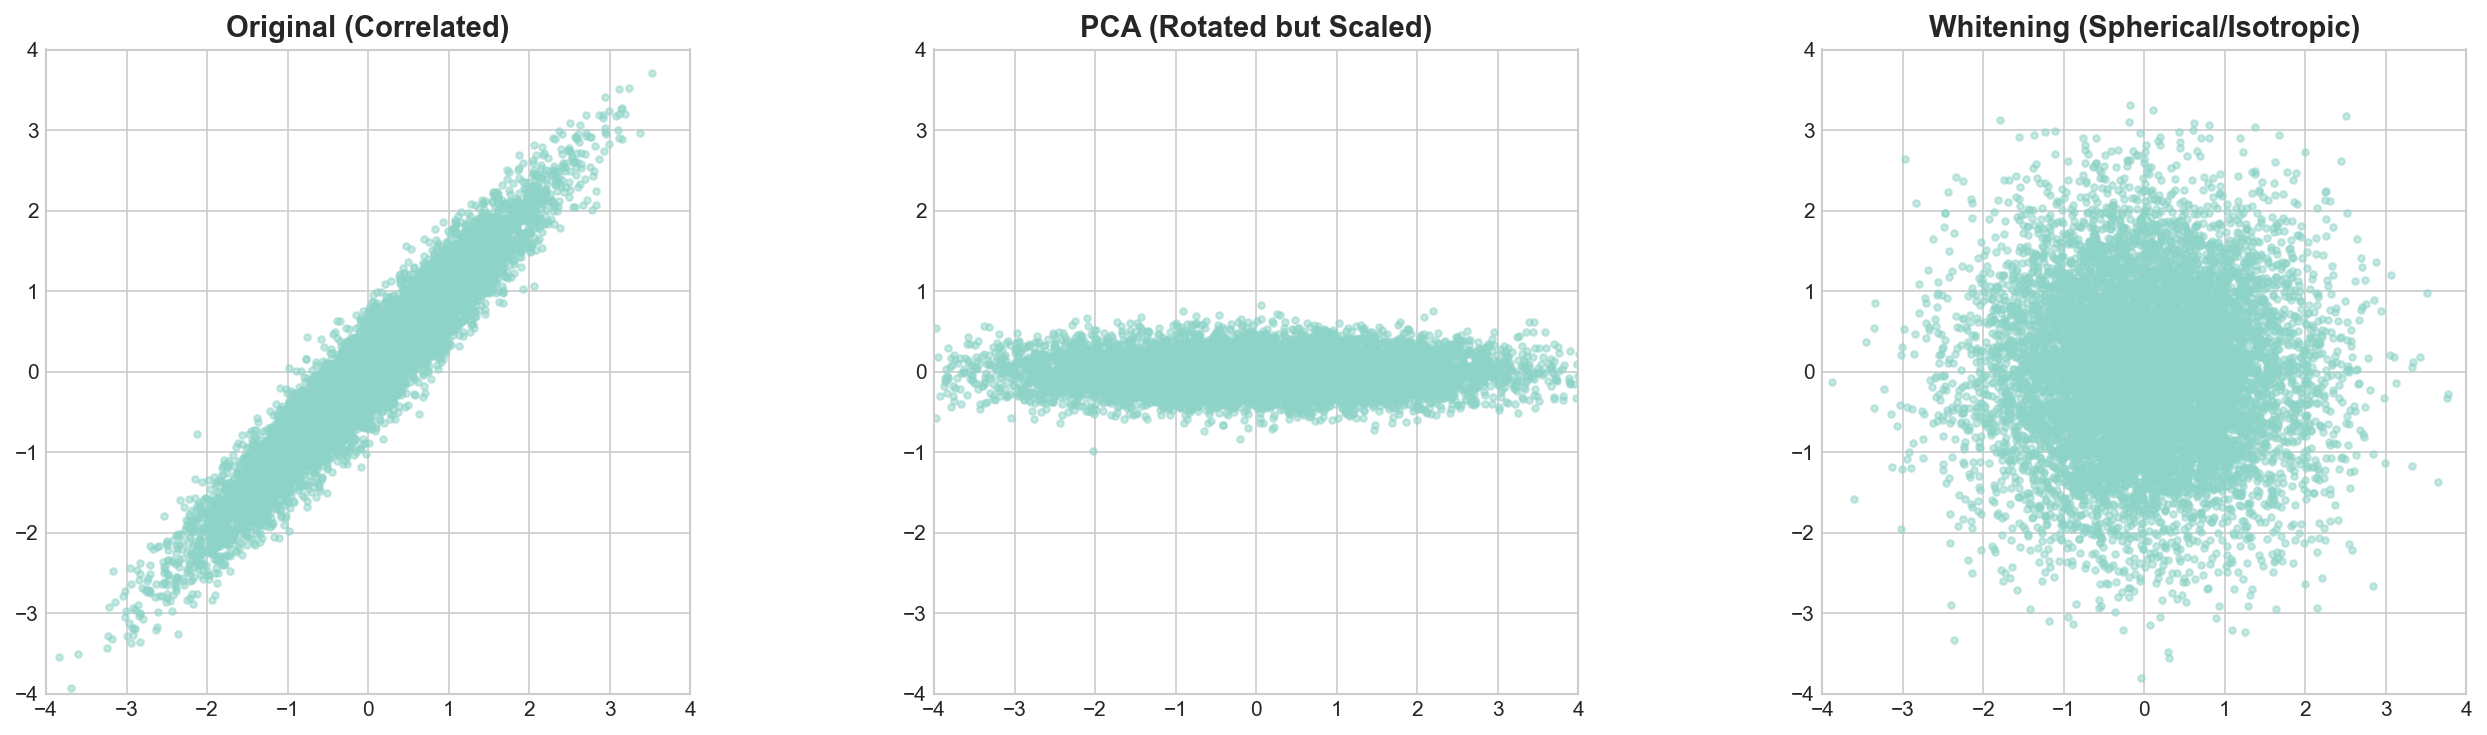

In [5]:
def generate_cigar_data(n: int = 10000) -> np.ndarray:
    """Generates highly correlated 2D data (Cigar shape)."""
    # X ~ N(0, 1), Y = X + noise -> Strong correlation
    X = np.random.randn(n, 1)
    Y = X + np.random.randn(n, 1) * 0.3
    return np.hstack([X, Y])

# 1. Generate Data
data = generate_cigar_data()

# 2. Apply PCA (Rotation only)x1
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# 3. Apply Whitening (Sphering)
cov = np.cov(data, rowvar=False)
W = fractional_matrix_power(cov, -0.5)
data_white = (data - np.mean(data, axis=0)) @ W

# --- PLOTTING ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ["Original (Correlated)", "PCA (Rotated but Scaled)", "Whitening (Spherical/Isotropic)"]
datasets = [data, data_pca, data_white]

for ax, ds, title in zip(axes, datasets, titles):
    ax.scatter(ds[:, 0], ds[:, 1], alpha=0.5, s=10)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal', 'box') # Crucial to see the shape
    ax.set_xlim(-4, 4); ax.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

Comparison Summary:
MKDE Time: 0.1118s
FDE Time: 0.8531s


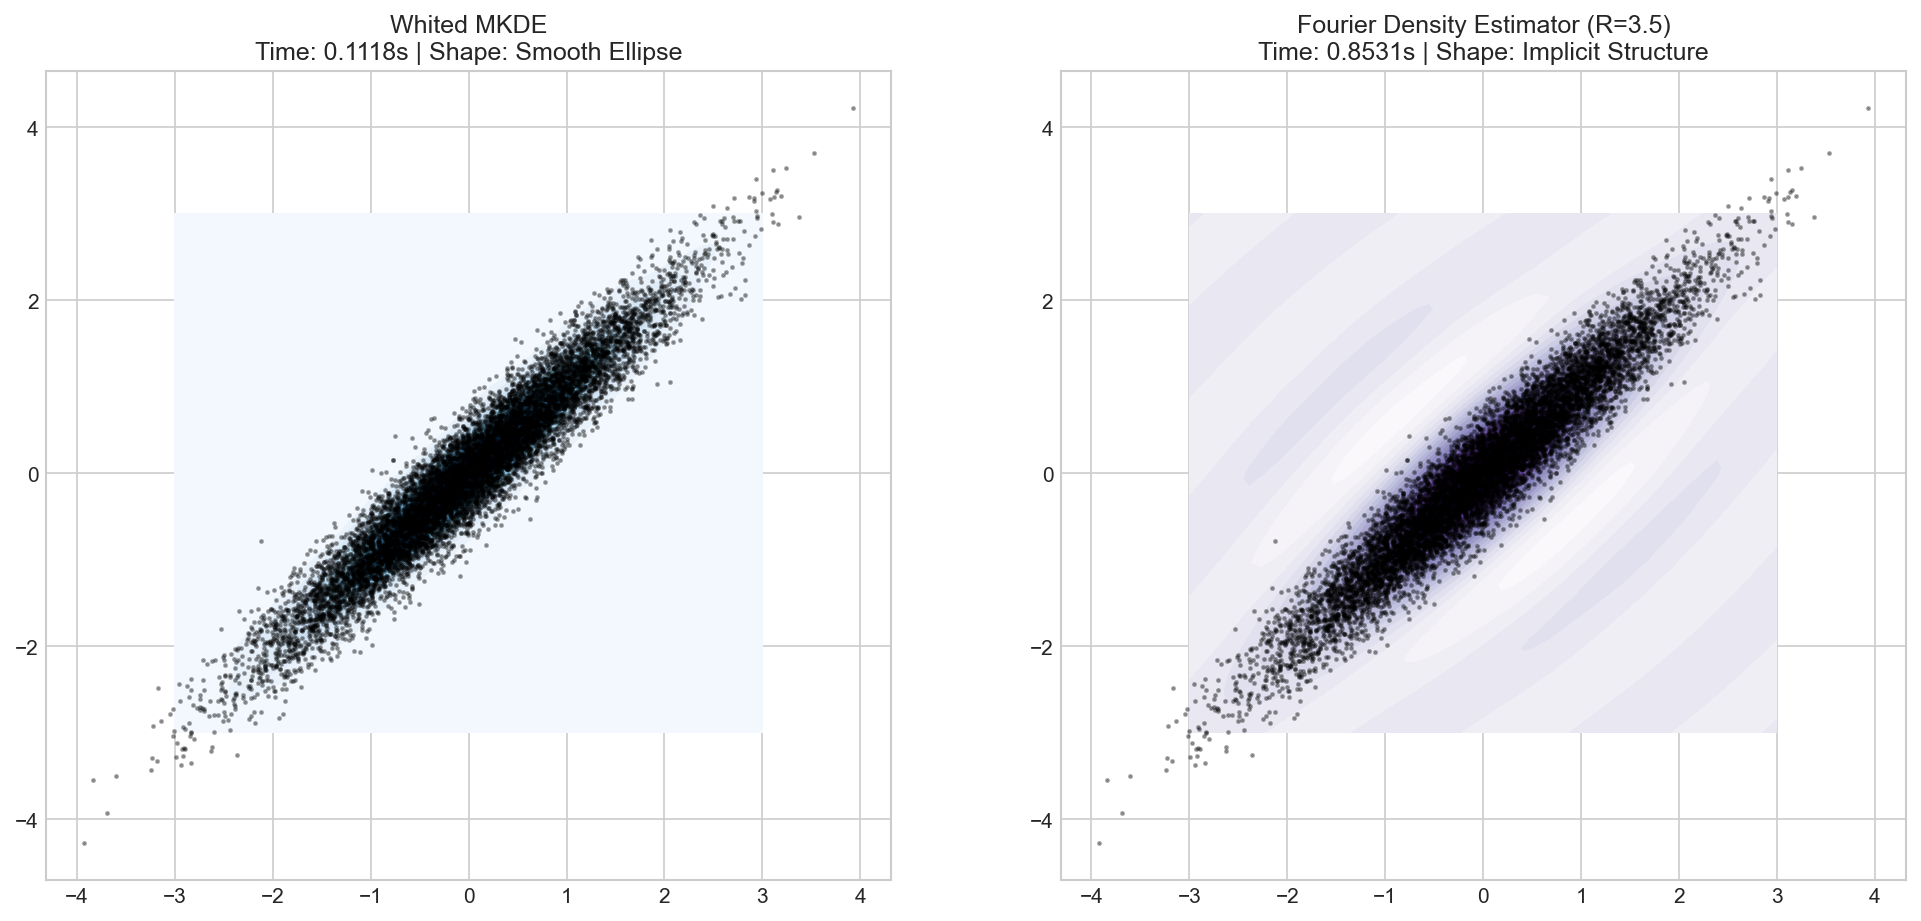

In [6]:
# Setup Grid for Visualization
x_min, x_max, y_min, y_max = -3, 3, -3, 3
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# --- 1. Run Whited MKDE ---
start_time = time.time()
mkde = WhitedMKDE().fit(data)
z_mkde = mkde.score_samples(grid_points).reshape(xx.shape)
mkde_time = time.time() - start_time

# --- 2. Run FDE (Retina Resolution) ---
# Heuristic R: With n=500, let's pick R=3.5 for sharpness
start_time = time.time()
fde = FourierDensityEstimator(radius=3.5).fit(data)
z_fde = fde.score_samples(grid_points).reshape(xx.shape)
fde_time = time.time() - start_time

# --- VISUALIZATION ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot MKDE
ax[0].contourf(xx, yy, z_mkde, levels=20, cmap='Blues')
ax[0].scatter(data[:, 0], data[:, 1], s=2, color='black', alpha=0.3)
ax[0].set_title(f"Whited MKDE\nTime: {mkde_time:.4f}s | Shape: Smooth Ellipse")

# Plot FDE
# Note: FDE can produce negative ripples, we clip slightly for nicer visual or keep raw
ax[1].contourf(xx, yy, z_fde, levels=20, cmap='Purples')
ax[1].scatter(data[:, 0], data[:, 1], s=2, color='black', alpha=0.3)
ax[1].set_title(f"Fourier Density Estimator (R={fde.radius})\nTime: {fde_time:.4f}s | Shape: Implicit Structure")

print(f"Comparison Summary:\nMKDE Time: {mkde_time:.4f}s\nFDE Time: {fde_time:.4f}s")
plt.show()

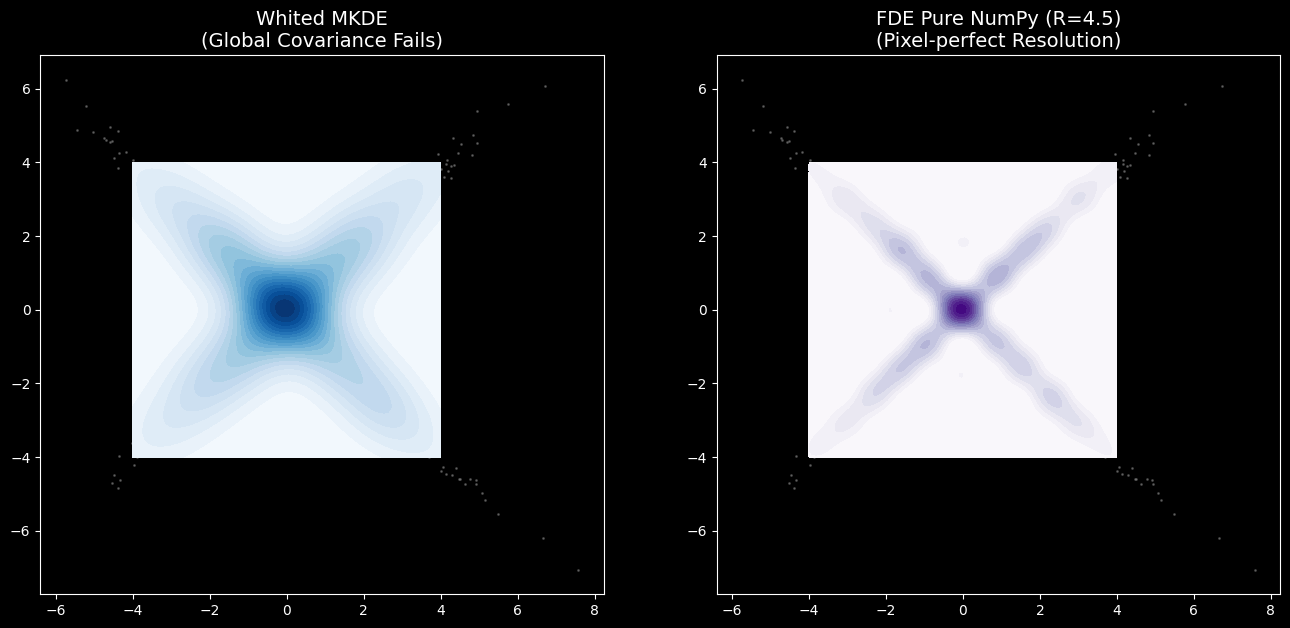

In [1]:
"""
Advanced Density Estimation Benchmark: The 'X' Manifold.
NO-NUMBA VERSION (Pure NumPy Implementation).

This script demonstrates the robustness of FDE against Global Whitening failure
using standard NumPy broadcasting.

Environment: Jupyter / DataSpell
Dependencies: numpy, matplotlib, scipy
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.linalg import fractional_matrix_power
import time

# --- 1. Pure NumPy FDE Implementation (Vectorized) ---
class FourierDensityEstimatorNumpy:
    """
    FDE implementation using NumPy Broadcasting.
    No Numba, no compilation. Pure linear algebra.
    """
    def __init__(self, radius: float = 3.0):
        self.radius = radius
        self.X_train = None

    def fit(self, X: np.ndarray):
        self.X_train = X
        return self

    def score_samples(self, X_test: np.ndarray) -> np.ndarray:
        if self.X_train is None: raise RuntimeError("Not fitted")

        n_train, d = self.X_train.shape
        n_test = X_test.shape[0]

        # Constant factor: 1 / (n * pi^d)
        const = 1.0 / (n_train * (np.pi ** d))

        # --- VECTORIZATION MAGIC (Broadcasting) ---
        # Shape transformation for broadcasting:
        # X_train: (n_train, 1, d)
        # X_test:  (1, n_test, d)
        # Diff:    (n_train, n_test, d)

        # Memory Warning: This creates a matrix of size N_train * N_test * d.
        # For 1000 train * 10000 test * 2 dim = 20 million floats (~160MB RAM).
        # Totally fine for your M3 Pro.

        diff = self.X_train[:, np.newaxis, :] - X_test[np.newaxis, :, :]

        # Calculate u = R * (x - Xi)
        u = self.radius * diff

        # Calculate Sinc: sin(u)/diff = R * sin(u)/u
        # We use np.sinc(x) which computes sin(pi*x)/(pi*x).
        # But paper uses sin(u)/u. Let's stick to raw sin for exact match with paper.

        with np.errstate(divide='ignore', invalid='ignore'):
            kernel_val = np.sin(u) / diff

        # Handle singularity (0/0) -> Limit is R
        kernel_val = np.where(diff == 0, self.radius, kernel_val)

        # Product over dimensions (axis 2) -> Shape: (n_train, n_test)
        prod_kernel = np.prod(kernel_val, axis=2)

        # Sum over training samples (axis 0) -> Shape: (n_test,)
        densities = const * np.sum(prod_kernel, axis=0)

        return densities

# --- 2. Whited MKDE Implementation (Standard Scipy) ---
class WhitedMKDE:
    def __init__(self):
        self.whitening_matrix = None
        self.kde_engine = None
        self.mean = None

    def fit(self, X: np.ndarray):
        self.mean = np.mean(X, axis=0)
        cov = np.cov(X, rowvar=False)
        try:
            self.whitening_matrix = fractional_matrix_power(cov, -0.5)
        except:
            self.whitening_matrix = np.eye(X.shape[1])

        X_whited = (X - self.mean) @ self.whitening_matrix
        self.kde_engine = gaussian_kde(X_whited.T)
        return self

    def score_samples(self, X_test: np.ndarray):
        X_test_whited = (X_test - self.mean) @ self.whitening_matrix
        d_z = self.kde_engine(X_test_whited.T)
        return d_z * np.linalg.det(self.whitening_matrix)

# --- 3. Data Generation (The "X" Shape) ---
def generate_crossing_data(n_samples: int = 1000):
    n_half = n_samples // 2
    # Arm 1 (+45 deg)
    X1 = np.random.randn(n_half, 2) * [3, 0.2]
    theta1 = np.pi / 4
    R1 = np.array([[np.cos(theta1), -np.sin(theta1)], [np.sin(theta1), np.cos(theta1)]])
    X1 = X1 @ R1.T
    # Arm 2 (-45 deg)
    X2 = np.random.randn(n_half, 2) * [3, 0.2]
    theta2 = -np.pi / 4
    R2 = np.array([[np.cos(theta2), -np.sin(theta2)], [np.sin(theta2), np.cos(theta2)]])
    X2 = X2 @ R2.T
    return np.vstack([X1, X2])

# --- 4. Benchmark Runner ---
def run_benchmark_pure_numpy():
    print("Generating 'X' Manifold Data...")
    X = generate_crossing_data(1000)

    # Grid Setup
    x_grid = np.linspace(-4, 4, 100)
    y_grid = np.linspace(-4, 4, 100)
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 1. MKDE
    print("Running Whited MKDE...")
    t0 = time.time()
    mkde = WhitedMKDE().fit(X)
    z_mkde = mkde.score_samples(grid_points).reshape(xx.shape)
    t_mkde = time.time() - t0

    # 2. FDE (Pure NumPy)
    print("Running FDE (Pure NumPy)...")
    # Using R=4.5 to get sharp definition
    t0 = time.time()
    fde = FourierDensityEstimatorNumpy(radius=4.5).fit(X)
    z_fde = fde.score_samples(grid_points).reshape(xx.shape)
    t_fde = time.time() - t0

    print(f"\nTiming Result:\nMKDE (Scipy): {t_mkde:.4f}s\nFDE (NumPy):  {t_fde:.4f}s")

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # MKDE Plot
    ax[0].scatter(X[:, 0], X[:, 1], s=1, c='gray', alpha=0.5)
    ax[0].contourf(xx, yy, z_mkde, levels=20, cmap='Blues')
    ax[0].set_title("Whited MKDE\n(Global Covariance Fails)", fontsize=14)

    # FDE Plot
    # Clipping negative values for better visualization
    z_fde_clean = np.maximum(z_fde, 0)
    ax[1].scatter(X[:, 0], X[:, 1], s=1, c='gray', alpha=0.5)
    ax[1].contourf(xx, yy, z_fde_clean, levels=20, cmap='Purples')
    ax[1].set_title(f"FDE Pure NumPy (R={fde.radius})\n(Pixel-perfect Resolution)", fontsize=14)

    plt.show()

if __name__ == "__main__":
    run_benchmark_pure_numpy()

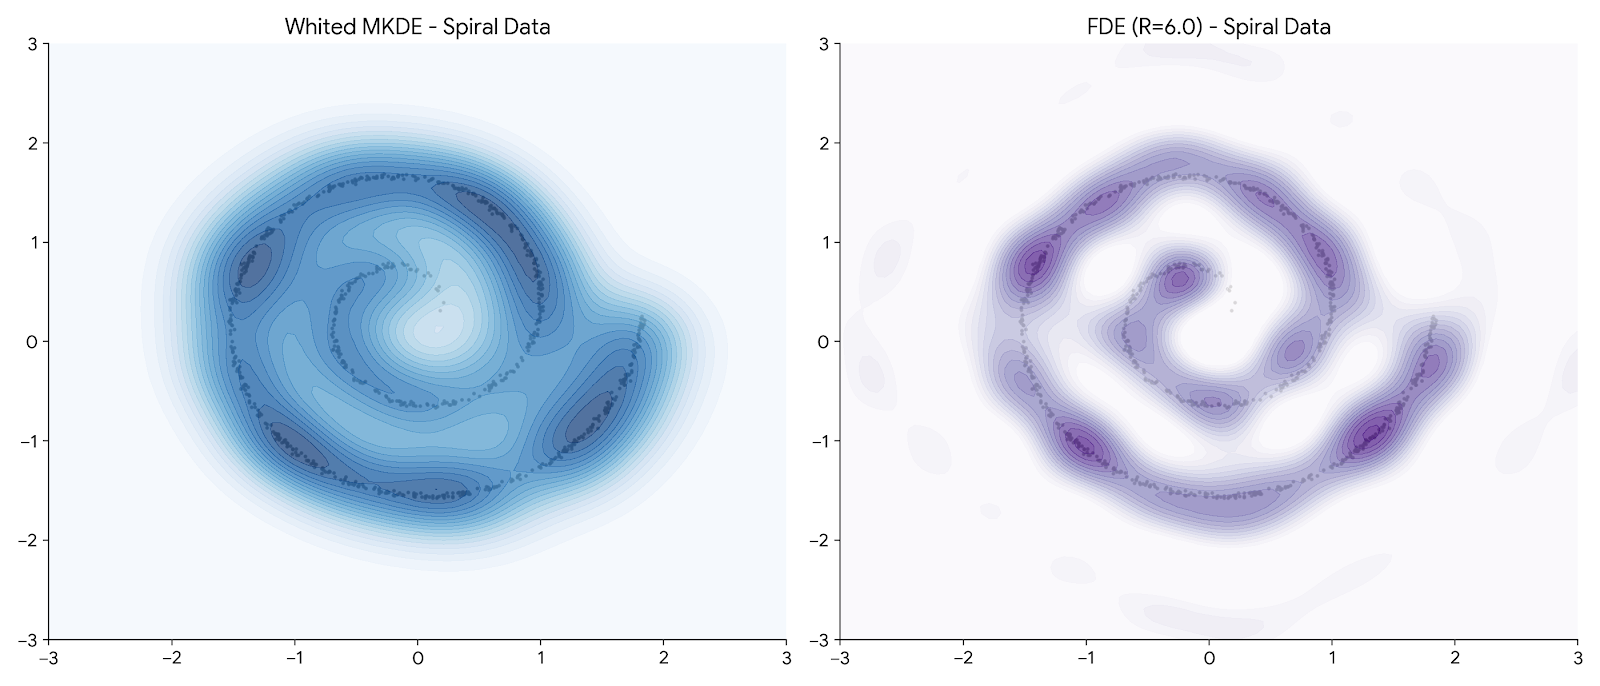

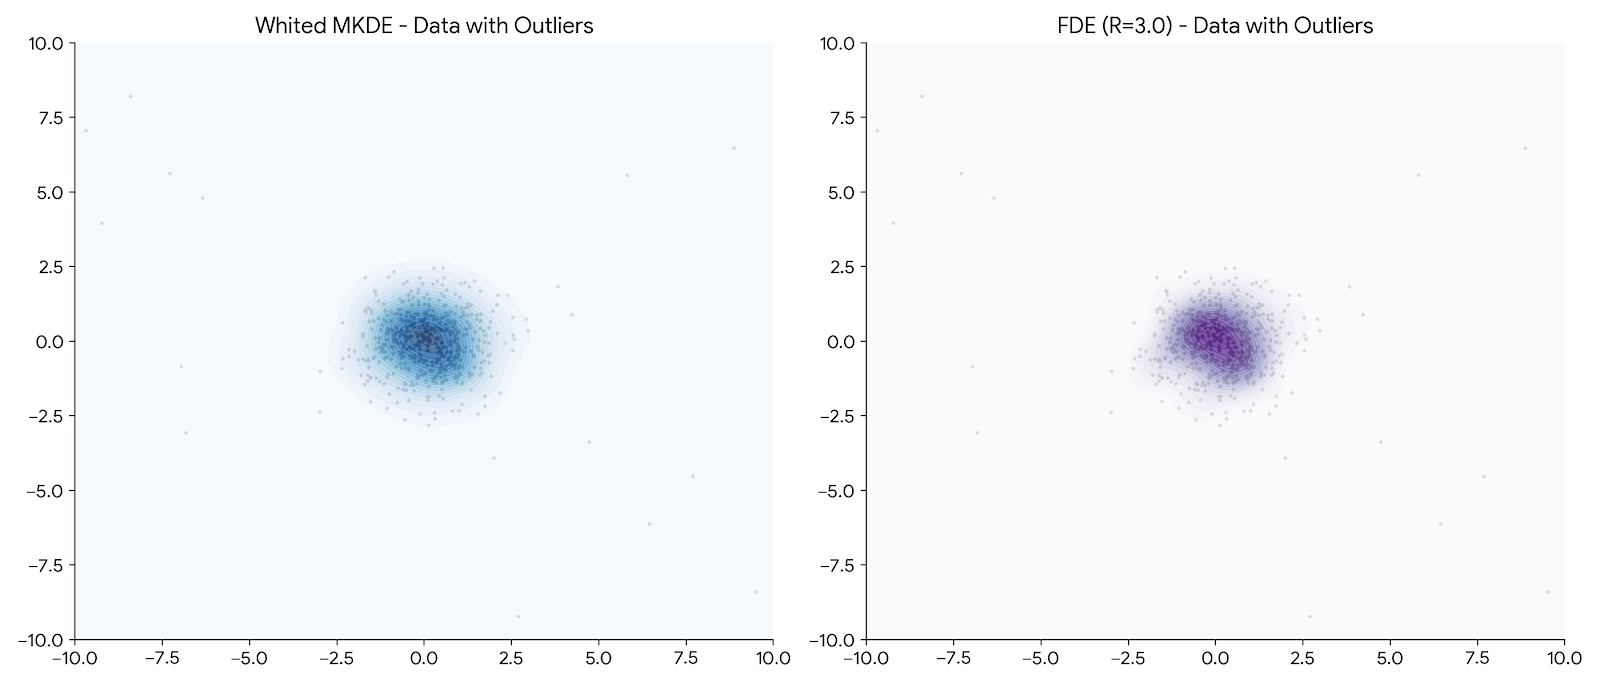